In [1]:
import os
import gym
from gym import wrappers
import numpy as np

In [19]:
from keras.layers import Dense, Activation, Conv2D, Flatten
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np

class ReplayBuffer(object):
    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.mem_cntr = 0

        self.state_memory = np.zeros((self.mem_size, input_shape),
                                      dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, input_shape),
                                          dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.uint8)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims,)),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model

class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size, replace,
                 input_dims, eps_dec=0.996,  eps_min=0.01,
                 mem_size=1000000, q_eval_fname='q_eval.h5',
                 q_target_fname='q_next.h5'):
        self.action_space = [i for i in range(n_actions)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.batch_size = batch_size
        self.replace = replace
        self.q_target_model_file = q_target_fname
        self.q_eval_model_file = q_eval_fname
        self.learn_step = 0
        self.memory = ReplayBuffer(mem_size, input_dims)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)
        self.q_next = build_dqn(alpha, n_actions, input_dims, 256, 256)

    def replace_target_network(self):
        if self.replace is not None and self.learn_step % self.replace == 0:
            self.q_next.set_weights(self.q_eval.get_weights())

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            state = np.array([observation], copy=False, dtype=np.float32)
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                                    self.memory.sample_buffer(self.batch_size)

            self.replace_target_network()

            q_eval = self.q_eval.predict(state)

            q_next = self.q_next.predict(new_state)

            """
            Thanks to Maximus-Kranic for pointing out this subtle bug.
            q_next[done] = 0.0 works in Torch; it sets q_next to 0
            for every index that done == 1. The behavior is different in
            Keras, as you can verify by printing out q_next to the terminal
            when done.any() == 1.
            Despite this, the agent still manages to learn. Odd.
            The correct implementation in Keras is to use q_next * (1-done)
            q_next[done] = 0.0
            q_target = q_eval[:]
            indices = np.arange(self.batch_size)
            q_target[indices, action] = reward + \
                                        self.gamma*np.max(q_next,axis=1)
            """
            q_target = q_eval[:]
            indices = np.arange(self.batch_size)
            q_target[indices, action] = reward + \
                                    self.gamma*np.max(q_next, axis=1)*(1 - done)
            self.q_eval.train_on_batch(state, q_target)

            self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min
            self.learn_step += 1

    def save_models(self):
        self.q_eval.save(self.q_eval_model_file)
        self.q_next.save(self.q_target_model_file)
        print('... saving models ...')

    def load_models(self):
        self.q_eval = load_model(self.q_eval_model_file)
        self.q_nexdt = load_model(self.q_target_model_file)
        print('... loading models ...')

In [21]:

import numpy as np
import gym
from gym import wrappers


if __name__ == '__main__':
    env = gym.make('CartPole-v0')
    lr = 0.0005
    n_games = 300
    agent = Agent(gamma=0.99, epsilon=0.0, alpha=lr, input_dims=4,
                  n_actions=2, mem_size=1000000, batch_size=64, eps_min=0.01,replace = 100) 
    scores = []
    eps_history = []

    #env = wrappers.Monitor(env, "tmp/lunar-lander-6",
    #                         video_callable=lambda episode_id: True, force=True)

    for i in range(n_games):
        done = False
        score = 0
        observation = env.reset()
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            score += reward
            agent.remember(observation, action, reward, observation_, int(done))
            observation = observation_
            agent.learn()

        eps_history.append(agent.epsilon)
        scores.append(score)
        
        avg_score = np.mean(scores[max(0, i-100):(i+1)])
        print('episode: ', i,'score: %.2f' % score,
              ' average score %.2f' % avg_score)

        if i % 10 == 0 and i > 0:
            agent.save_models()

c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


episode:  0 score: 10.00  average score 10.00
episode:  1 score: 9.00  average score 9.50
episode:  2 score: 8.00  average score 9.00
episode:  3 score: 10.00  average score 9.25
episode:  4 score: 9.00  average score 9.20
episode:  5 score: 10.00  average score 9.33
episode:  6 score: 9.00  average score 9.29
episode:  7 score: 9.00  average score 9.25
episode:  8 score: 9.00  average score 9.22
episode:  9 score: 10.00  average score 9.30
episode:  10 score: 8.00  average score 9.18
... saving models ...
episode:  11 score: 9.00  average score 9.17
episode:  12 score: 10.00  average score 9.23
episode:  13 score: 10.00  average score 9.29
episode:  14 score: 9.00  average score 9.27
episode:  15 score: 10.00  average score 9.31
episode:  16 score: 10.00  average score 9.35
episode:  17 score: 10.00  average score 9.39
episode:  18 score: 10.00  average score 9.42
episode:  19 score: 9.00  average score 9.40
episode:  20 score: 10.00  average score 9.43
... saving models ...
episode: 

episode:  167 score: 182.00  average score 128.25
episode:  168 score: 173.00  average score 129.86
episode:  169 score: 177.00  average score 131.52
episode:  170 score: 200.00  average score 133.42
... saving models ...
episode:  171 score: 157.00  average score 134.88
episode:  172 score: 200.00  average score 136.76
episode:  173 score: 200.00  average score 138.64
episode:  174 score: 188.00  average score 140.41
episode:  175 score: 186.00  average score 142.15
episode:  176 score: 176.00  average score 143.78
episode:  177 score: 200.00  average score 145.66
episode:  178 score: 185.00  average score 147.41
episode:  179 score: 200.00  average score 149.30
episode:  180 score: 152.00  average score 150.71
... saving models ...
episode:  181 score: 193.00  average score 152.54
episode:  182 score: 200.00  average score 154.43
episode:  183 score: 170.00  average score 156.01
episode:  184 score: 200.00  average score 157.89
episode:  185 score: 200.00  average score 159.77
episod

Text(0.5,1,'DQN for CartPole-v0')

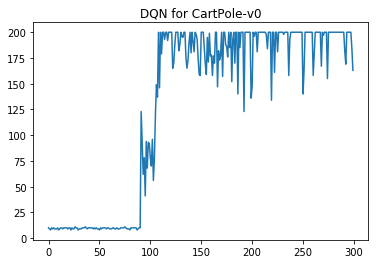

In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.arange(n_games),scores)
plt.title('DQN for CartPole-v0')